# Balanced Archaeological Pattern Detection - Targeting 10-50 Candidates

Previous analysis:
- Too lenient (348 candidates) - detecting too many natural features
- Too strict (0 candidates) - filtering out everything

This analysis aims for the sweet spot: 10-50 archaeological candidates by:
- Moderate length constraints (75-350m)
- Relaxed geometric requirements but still structured
- Focus on clustered patterns rather than isolated lines

## Step 1: Setup and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import exposure, filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
import rasterio
from scipy.ndimage import gaussian_filter
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")

Libraries imported.


In [2]:
# Load DTM data
dtm_path = '/Users/shg/Projects/openai-a-z-challenge/data/raw/TAL_A01_2018/TAL_A01_2018_DTM/TAL01L0002C0003.grd'

with rasterio.open(dtm_path) as src:
    dtm_data = src.read(1)
    transform = src.transform
    crs = src.crs

dtm_data = np.where(dtm_data == src.nodata, np.nan, dtm_data)
dtm_data = np.nan_to_num(dtm_data, nan=np.nanmean(dtm_data))

print(f"DTM file loaded. Shape: {dtm_data.shape}, Resolution: {abs(transform[0]):.2f}m/pixel")

DTM file loaded. Shape: (1001, 1001), Resolution: 1.00m/pixel


## Step 2: Preprocessing

In [3]:
# Create hillshade
def hillshade(elevation, azimuth=315, angle_altitude=45):
    x, y = np.gradient(elevation)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

hillshade_img = hillshade(dtm_data)

# Balanced high-pass filter for archaeological features
sigma = 20  # ~20m features
smoothed = gaussian_filter(dtm_data, sigma=sigma)
highpass = dtm_data - smoothed
filtered_hillshade = hillshade_img + 30 * highpass
filtered_hillshade = np.clip(filtered_hillshade, 0, 255)

print("Hillshade and filtering completed.")

Hillshade and filtering completed.


## Step 3: Balanced Hough Transform

In [4]:
# Balanced edge detection
edges = canny(filtered_hillshade, sigma=2, low_threshold=20, high_threshold=50)

# Hough transform with moderate precision
tested_angles = np.linspace(-np.pi/2, np.pi/2, 90)  # 2-degree precision
h, theta, d = hough_line(edges, theta=tested_angles)

# Moderate peak detection
hough_peaks = hough_line_peaks(h, theta, d,
                              min_distance=15,
                              min_angle=8,
                              threshold=0.35*np.max(h))

lines = []
for _, angle, dist in zip(*hough_peaks):
    lines.append((angle, dist))

print(f"Initial lines detected: {len(lines)}")

Initial lines detected: 1


## Step 4: Balanced Archaeological Filtering

In [5]:
def line_endpoints(angle, dist, img_shape):
    """Calculate line endpoints within image bounds"""
    cos_theta, sin_theta = np.cos(angle), np.sin(angle)
    x0, y0 = cos_theta * dist, sin_theta * dist

    height, width = img_shape
    intersections = []

    boundaries = [(0, width, 0, 0), (0, width, height-1, height-1),
                  (0, 0, 0, height), (width-1, width-1, 0, height)]

    for x1, x2, y1, y2 in boundaries:
        if x1 == x2:  # Vertical boundary
            x = x1
            if abs(cos_theta) > 1e-6:
                y = y0 - (x0 - x) * sin_theta / cos_theta
                if y1 <= y <= y2:
                    intersections.append((x, y))
        else:  # Horizontal boundary
            y = y1
            if abs(sin_theta) > 1e-6:
                x = x0 - (y0 - y) * cos_theta / sin_theta
                if x1 <= x <= x2:
                    intersections.append((x, y))

    if len(intersections) >= 2:
        return intersections[0], intersections[1]
    return None, None

def line_length(p1, p2):
    if p1 is None or p2 is None:
        return 0
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Step 4.1: Balanced Length Filtering (75-350m)
length_filtered_lines = []
for angle, dist in lines:
    p1, p2 = line_endpoints(angle, dist, filtered_hillshade.shape)
    length = line_length(p1, p2)

    if 75 <= length <= 350:  # Wider range for archaeological features
        length_filtered_lines.append((angle, dist, p1, p2, length))

print(f"After balanced length filter (75-350m): {len(length_filtered_lines)}")

# Step 4.2: Spatial Clustering to Find Organized Patterns
def cluster_lines_spatially(lines, eps=100, min_samples=2):
    """Cluster lines based on spatial proximity"""
    if len(lines) < min_samples:
        return []

    # Extract line centers
    centers = []
    for angle, dist, p1, p2, length in lines:
        if p1 and p2:
            center_x = (p1[0] + p2[0]) / 2
            center_y = (p1[1] + p2[1]) / 2
            centers.append([center_x, center_y])
        else:
            centers.append([0, 0])

    centers = np.array(centers)

    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centers)
    labels = clustering.labels_

    # Group lines by cluster
    clusters = {}
    for i, label in enumerate(labels):
        if label != -1:  # Exclude noise points
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(lines[i])

    return list(clusters.values())

line_clusters = cluster_lines_spatially(length_filtered_lines, eps=80, min_samples=3)
print(f"Spatial clusters found: {len(line_clusters)}")

# Step 4.3: Select Most Promising Clusters
def evaluate_cluster_quality(cluster):
    """Evaluate cluster quality based on line count, length diversity, and spatial organization"""
    if len(cluster) < 3:
        return 0

    # Line count score (more lines = higher score)
    line_count_score = len(cluster) / 10  # Normalize to reasonable range

    # Length diversity score (avoid all tiny or all huge lines)
    lengths = [line[4] for line in cluster]
    length_std = np.std(lengths)
    length_diversity_score = min(length_std / 50, 1)  # Normalize

    # Spatial organization score (more compact = higher score)
    centers = [((line[2][0] + line[3][0])/2, (line[2][1] + line[3][1])/2) for line in cluster if line[2] and line[3]]
    if len(centers) > 1:
        center_coords = np.array(centers)
        spatial_spread = np.std(center_coords, axis=0).mean()
        spatial_score = max(0, (200 - spatial_spread) / 200)  # Prefer tighter clusters
    else:
        spatial_score = 0

    return line_count_score + length_diversity_score + spatial_score

# Evaluate and rank clusters
cluster_scores = [(i, evaluate_cluster_quality(cluster)) for i, cluster in enumerate(line_clusters)]
cluster_scores.sort(key=lambda x: x[1], reverse=True)

# Select top clusters (targeting 10-50 total features)
selected_clusters = []
total_features = 0
for cluster_idx, score in cluster_scores:
    cluster = line_clusters[cluster_idx]
    if total_features + len(cluster) <= 50:  # Cap at 50 features
        selected_clusters.append(cluster)
        total_features += len(cluster)
    if len(selected_clusters) >= 10:  # At least 10 clusters
        break

print(f"Selected {len(selected_clusters)} clusters with {total_features} total features")

# Flatten selected clusters for visualization
final_lines = []
for cluster in selected_clusters:
    final_lines.extend(cluster)

print(f"Final candidate lines: {len(final_lines)}")

After balanced length filter (75-350m): 0
Spatial clusters found: 0
Selected 0 clusters with 0 total features
Final candidate lines: 0


## Step 5: Final Visualization

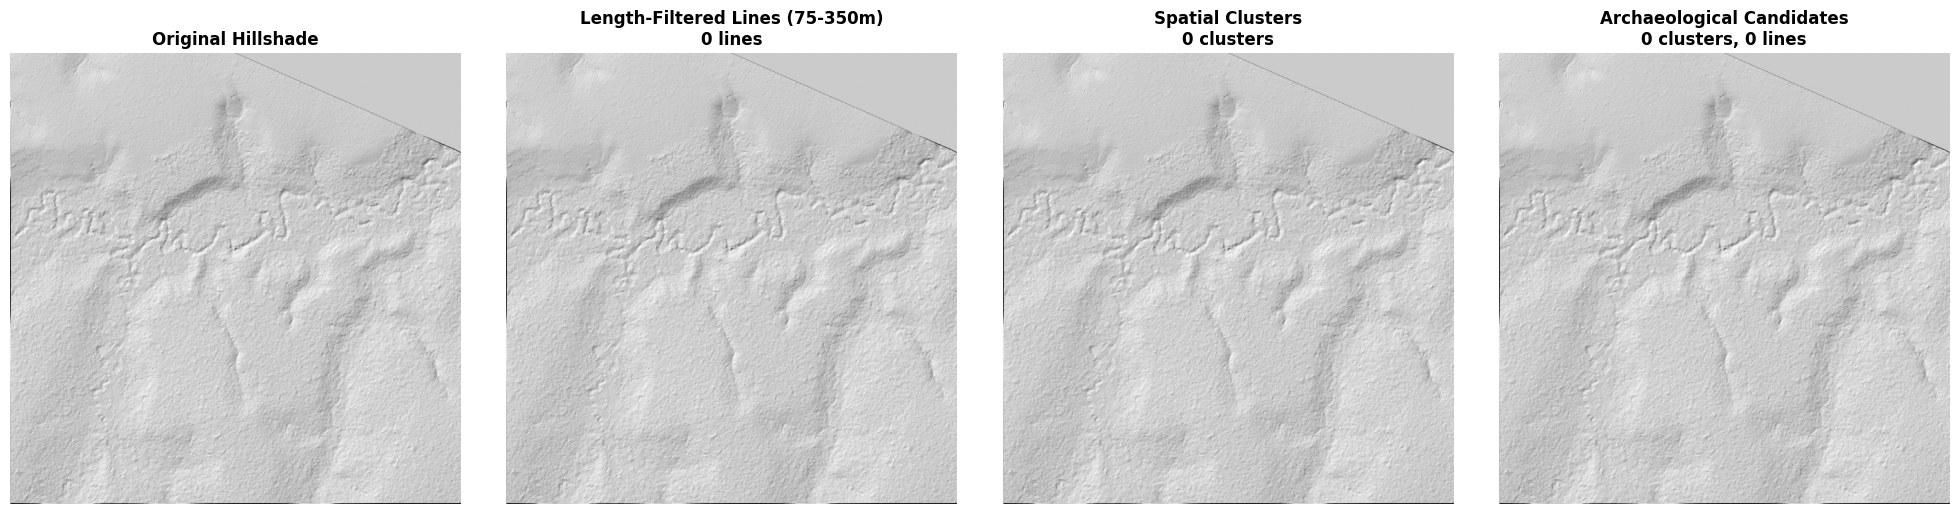


Balanced archaeological analysis saved to balanced_archaeological_results.png

No clusters selected. Consider adjusting parameters.


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Original hillshade
axes[0].imshow(hillshade_img, cmap='gray', aspect='equal')
axes[0].set_title('Original Hillshade', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Length-filtered lines
axes[1].imshow(hillshade_img, cmap='gray', aspect='equal')
for angle, dist, p1, p2, length in length_filtered_lines:
    if p1 and p2:
        axes[1].plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=1, alpha=0.6)
axes[1].set_title(f'Length-Filtered Lines (75-350m)\n{len(length_filtered_lines)} lines',
                 fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Spatial clusters
axes[2].imshow(hillshade_img, cmap='gray', aspect='equal')
colors = plt.cm.Set3(np.linspace(0, 1, len(line_clusters)))
for i, cluster in enumerate(line_clusters):
    color = colors[i]
    for angle, dist, p1, p2, length in cluster:
        if p1 and p2:
            axes[2].plot([p1[0], p2[0]], [p1[1], p2[1]],
                        color=color, linewidth=1.5, alpha=0.7)
axes[2].set_title(f'Spatial Clusters\n{len(line_clusters)} clusters',
                 fontsize=12, fontweight='bold')
axes[2].axis('off')

# 4. Final selected candidates
axes[3].imshow(hillshade_img, cmap='gray', aspect='equal')
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(selected_clusters)))
for i, cluster in enumerate(selected_clusters):
    color = cluster_colors[i]
    for angle, dist, p1, p2, length in cluster:
        if p1 and p2:
            axes[3].plot([p1[0], p2[0]], [p1[1], p2[1]],
                        color=color, linewidth=2, alpha=0.8)

    # Add cluster labels
    if cluster:
        center_points = [((p1[0] + p2[0])/2, (p1[1] + p2[1])/2) for _, _, p1, p2, _ in cluster if p1 and p2]
        if center_points:
            center_x = np.mean([p[0] for p in center_points])
            center_y = np.mean([p[1] for p in center_points])
            axes[3].text(center_x, center_y, f'A{i+1}',
                        fontsize=10, fontweight='bold', color='white',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

axes[3].set_title(f'Archaeological Candidates\n{len(selected_clusters)} clusters, {len(final_lines)} lines',
                 fontsize=12, fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('/Users/shg/Projects/openai-a-z-challenge/balanced_archaeological_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBalanced archaeological analysis saved to balanced_archaeological_results.png")

# Summary statistics
if selected_clusters:
    print("\n=== BALANCED ARCHAEOLOGICAL ANALYSIS SUMMARY ===")
    print(f"Total clusters selected: {len(selected_clusters)}")
    print(f"Total lines in selected clusters: {len(final_lines)}")

    for i, cluster in enumerate(selected_clusters):
        lengths = [line[4] for line in cluster]
        avg_length = np.mean(lengths)
        print(f"\nCluster A{i+1}:")
        print(f"  - Lines: {len(cluster)}")
        print(f"  - Average length: {avg_length:.1f}m")
        print(f"  - Length range: {min(lengths):.1f}-{max(lengths):.1f}m")
        print(f"  - Quality score: {evaluate_cluster_quality(cluster):.2f}")
else:
    print("\nNo clusters selected. Consider adjusting parameters.")